# Module 4 Brief 2

## Imports

Nous allons importer le dataset MNIST et les dépendances dont nous aurons besoin.

In [141]:
from tensorflow.keras.datasets import mnist
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
%matplotlib inline


In [142]:
(X_train_raw, _), (X_test_raw, _) = mnist.load_data()
X = np.concatenate([X_train_raw, X_test_raw], axis=0).astype(np.float32)

## Exemple

Le dataset MNIST contient des images de chiffres manuscrits, représentés par une valeur entre 0 et 255 pour chaque pixel correspondant à une nuance de gris.

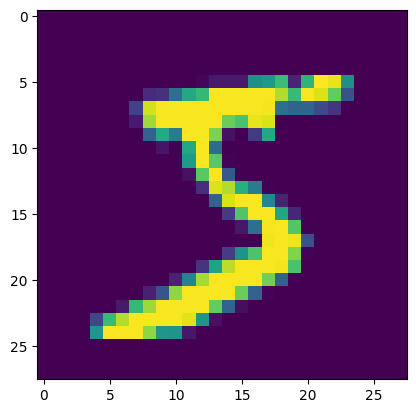

In [143]:
plt.imshow(X[0])

### Normalisation

In [144]:
X_flat = X.reshape(-1, 28 * 28)
X_norm = X_flat / 255

## Clustering (k-means)

Nous savons que chaque entrée de notre dataset représente un chiffre. Par conséquent, nous cherchons à identifier 10 clusters, un pour chaque chiffre possible.

In [145]:
len(X)

70000

In [159]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#scaler_small = MinMaxScaler()
#X_small_normalized = scaler_small.fit_transform(X_train_norm)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_norm)

kmeans = KMeans(n_clusters=10, random_state=42, n_init=30)
clusters_kmeans = kmeans.fit_predict(X_norm) #X_small_normalized)

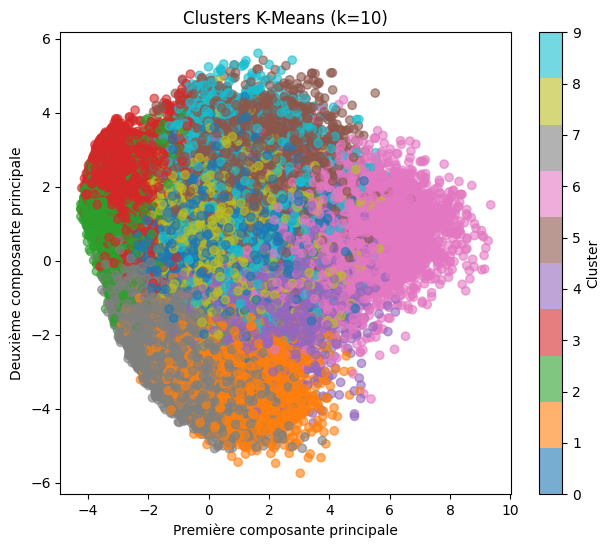

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters_kmeans, cmap='tab10', alpha=0.6)
axes[0].set_xlabel('Première composante principale')
axes[0].set_ylabel('Deuxième composante principale')
axes[0].set_title('Clusters K-Means (k=10)')

fig.delaxes(axes[1])

plt.colorbar(scatter1, ax=axes[0], label='Cluster')

## Train-test split

In [161]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_pca, clusters_kmeans, test_size=0.2, random_state=42)

## Régression logistique

In [162]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs', max_iter=3000)
log_reg.fit(X_train, y_train)

log_reg.score(X_test, y_test)

0.5093571428571428

### Matrice de confusion

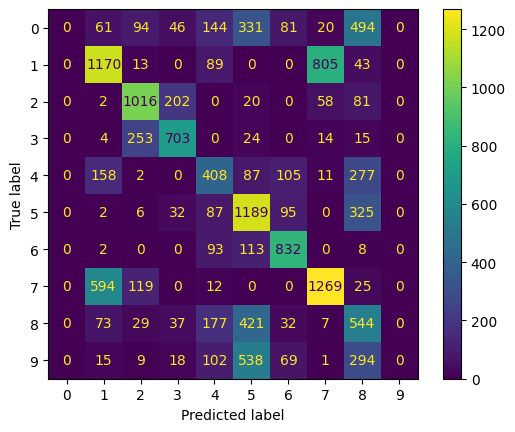

In [163]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Y_pred = log_reg.predict(X_test)

disp = ConfusionMatrixDisplay.from_estimator(
        log_reg,
        X_test,
        y_test,
    )
plt.show()

## Réseau neuronal convolutif (CNN)

### Création du modèle

In [157]:
from keras import models, layers

cnn = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),                      # Transforme le cube (3,3,64) en un vecteur plat
    layers.Dense(64, activation='relu'),    # Couche intermédiaire pour "réfléchir"
    layers.Dense(10)                       # Couche de sortie (10 neurones pour 10 classes)
])

cnn.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       692,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,578 (2.65 MB)

 Trainable params: 693,578 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement

In [158]:
from keras.src.losses import SparseCategoricalCrossentropy

cnn.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

X_images = X.reshape(-1, 28, 28, 1) / 255.0
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_images, clusters_kmeans, test_size=0.2, random_state=42
)

history = cnn.fit(X_train_cnn, y_train_cnn, epochs=10,
                    validation_data=(X_test_cnn, y_test_cnn))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn.evaluate(X_test,  y_test, verbose=2)

Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9307 - loss: 0.1785 - val_accuracy: 0.9585 - val_loss: 0.1052
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.9574 - loss: 0.1036 - val_accuracy: 0.9531 - val_loss: 0.1096
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 66s 38ms/step - accuracy: 0.9657 - loss: 0.0858 - val_accuracy: 0.9576 - val_loss: 0.1057
Epoch 4/10
 451/1750 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.9734 - loss: 0.0667

KeyboardInterrupt: 